# Hydrological Parameter Sensitivity in SWAT using the Morris Method

This notebook implements a global sensitivity analysis of selected SWAT hydrological parameters using the **Morris method (Method of Elementary Effects)**.

**Model setup**

- Hydrological model: SWAT (ArcSWAT 2012 project)
- Study output: monthly streamflow at the basin outlet
- Observed data: `data/Observed Streamflow.xlsx`
- Model output: `data/TxtInOut/output.rch`

**Parameters analysed (12)**

- CN2, SURLAG, SFTMP, SMTMP, SMFMX, SMFMN  
- GW_DELAY, ALPHA_BF, GWQMN, RCHRG_DP  
- SOL_K, SOL_AWC  

**Workflow**

1. Read observed streamflow from Excel.
2. Generate Morris samples using SALib.
3. For each parameter set:
   - Update SWAT input files (`.mgt`, `.bsn`, `.gw`, `.sol`)
   - Run `swat2012.exe` in `TxtInOut/`
   - Extract simulated discharge from `output.rch`
4. Compute two objective functions:
   - Range of simulated discharge (max − min)
   - Nash–Sutcliffe Efficiency (NSE)
5. Perform Morris analysis and plot μ* vs σ for both objectives.

Developed by **Hamidreza Naserian**.


                SWAT2022               
               Rev. 687               
      Soil & Water Assessment Tool    
               PC Version             
 Program reading from file.cio . . . executing

  Executing year    1
  Executing year    2

 Execution successfully completed 

Updated Parameters: CN2=30.00, SURLAG=17.16, SFTMP=-2.14, SMTMP=-5.00, SMFMX=7.43, SMFMN=2.71, GW_DELAY=28.57, ALPHA_BF=0.01, GWQMN=785.71, RCHRG_DP=0.20, SOL_K=171.43, SOL_AWC=0.01
Extracted Streamflow Values: [0.07888, 0.6465, 0.5668, 0.1341, 2.445, 1.6, 0.6845, 0.4361, 0.1909, 0.6308, 23.99, 1.369, 2.038, 0.1687, 2.346, 2.749, 1.233, 1.952, 0.2744, 0.4773, 14.48, 1.16, 4.199, 2.748]
                SWAT2022               
               Rev. 687               
      Soil & Water Assessment Tool    
               PC Version             
 Program reading from file.cio . . . executing

  Executing year    1
  Executing year    2

 Execution successfully completed 

Updated Parameters: CN2=30.00, SURLAG=1

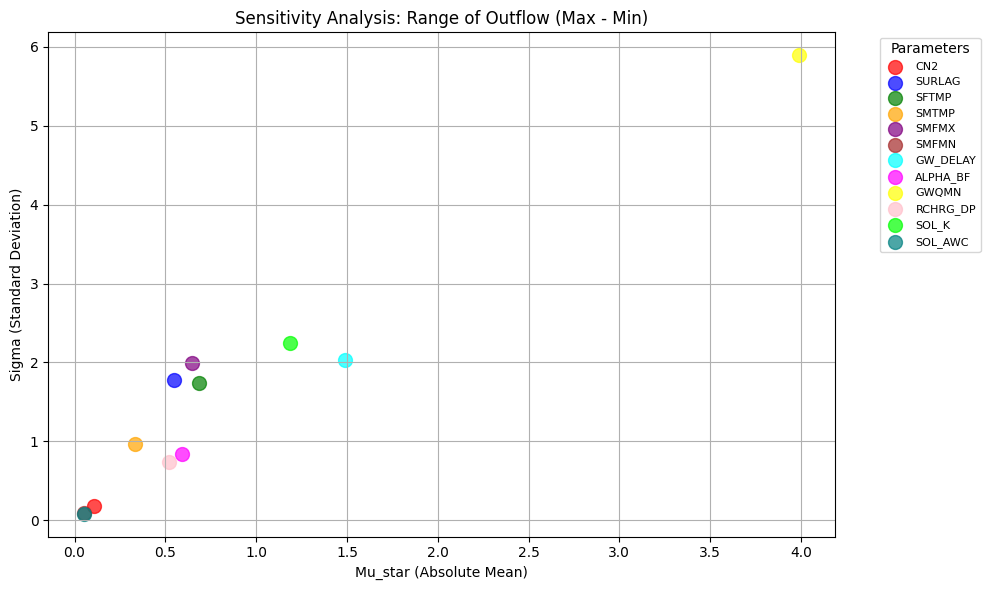

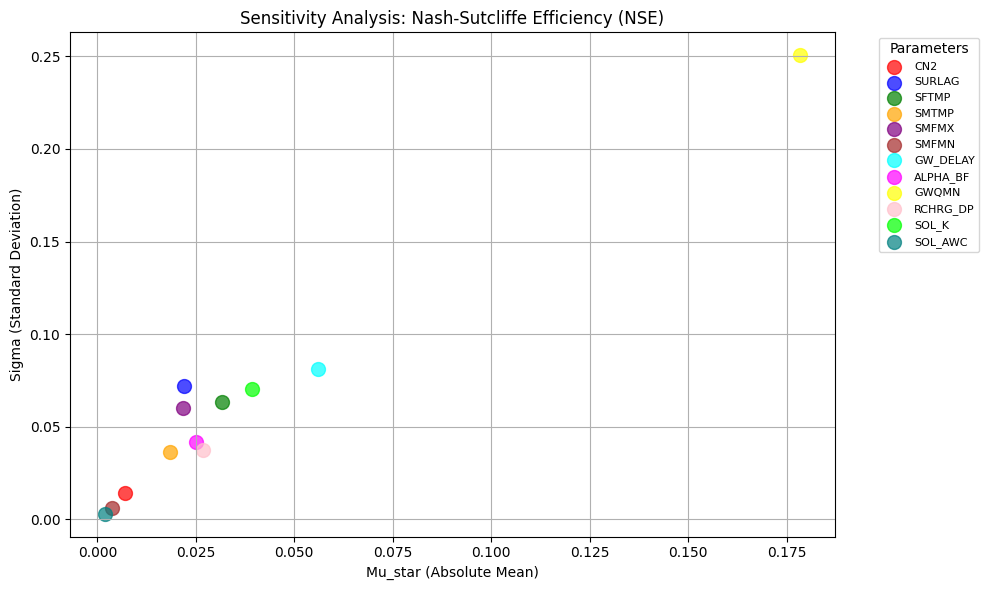

In [3]:
import os
import random
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install SALib openpyxl
from SALib.sample.morris import sample
from SALib.analyze.morris import analyze

# ---------------------------------------------------------------------------
# 1. Problem definition for the Morris method
# ---------------------------------------------------------------------------

problem = {
    "num_vars": 12,
    "names": [
        "CN2",
        "SURLAG",
        "SFTMP",
        "SMTMP",
        "SMFMX",
        "SMFMN",
        "GW_DELAY",
        "ALPHA_BF",
        "GWQMN",
        "RCHRG_DP",
        "SOL_K",
        "SOL_AWC",
    ],
    "bounds": [
        [30, 100],      # CN2
        [0.05, 24],     # SURLAG
        [-5, 5],        # SFTMP
        [-5, 5],        # SMTMP
        [4, 10],        # SMFMX
        [1, 4],         # SMFMN
        [5, 60],        # GW_DELAY
        [0.01, 0.5],    # ALPHA_BF
        [500, 1500],    # GWQMN
        [0.01, 0.2],    # RCHRG_DP
        [0.01, 300],    # SOL_K
        [0.01, 0.5],    # SOL_AWC
    ],
}


# ---------------------------------------------------------------------------
# 2. Paths (relative to this notebook / project folder)
# ---------------------------------------------------------------------------

PROJECT_ROOT = os.getcwd()                    # where the notebook is
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

folder_path = os.path.join(DATA_DIR, "TxtInOut")
observed_file_path = os.path.join(DATA_DIR, "Observed Streamflow.xlsx")
output_file_path = os.path.join(folder_path, "output.rch")
swat_exe_path = os.path.join(DATA_DIR, "swat2012.exe")

observed_data_column = "Observed Streamflow (m^3/s)"

# rows of output.rch to extract (0-based indices)
rows_to_extract = [
    38, 68, 98, 128, 158, 188, 218, 248, 278, 308, 338, 368,
    428, 458, 488, 518, 548, 578, 608, 638, 668, 698, 728, 758,
]
shift_spaces = 52  # number of characters to skip before reading discharge


# ---------------------------------------------------------------------------
# 3. Utility functions
# ---------------------------------------------------------------------------

def clamp(value, min_val, max_val):
    """Clamp a value between min_val and max_val."""
    return max(min(value, max_val), min_val)


def nse(observed, simulated):
    """Nash–Sutcliffe Efficiency."""
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)

    if len(observed) != len(simulated) or len(observed) == 0:
        return np.nan

    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    if denominator == 0:
        return np.nan

    return 1.0 - numerator / denominator


def range_of_outflow(simulated_outputs):
    """Range (max - min) of simulated discharge."""
    if simulated_outputs is None or len(simulated_outputs) == 0:
        return 0.0
    arr = np.asarray(simulated_outputs, dtype=float)
    return float(np.max(arr) - np.min(arr))


# ---------------------------------------------------------------------------
# 4. Function to update SWAT inputs and run the model
# ---------------------------------------------------------------------------

def update_and_run_swat(params):
    """
    Update SWAT input files based on the parameter set, run SWAT,
    and extract monthly simulated discharge from output.rch.

    Parameters
    ----------
    params : np.ndarray
        Array of 12 parameters in the same order as 'problem["names"]'.

    Returns
    -------
    list[float]
        List of simulated discharge values extracted from output.rch.
    """
    try:
        # ------------------------------
        # 4.1 Update CN2 in a .mgt file
        # ------------------------------
        mgt_files = [f for f in os.listdir(folder_path) if f.endswith(".mgt")]
        if not mgt_files:
            raise FileNotFoundError("No .mgt files found in folder_path.")

        selected_mgt_file = os.path.join(folder_path, random.choice(mgt_files))

        with open(selected_mgt_file, "r") as file:
            mgt_lines = file.readlines()

        # CN2 assumed at line index 10 (0-based)
        cn2_index = 10
        mgt_lines[cn2_index] = f"{params[0]:.2f}   | CN2: SCS Curve Number\n"

        with open(selected_mgt_file, "w") as file:
            file.writelines(mgt_lines)

        # ------------------------------
        # 4.2 Update basins.bsn
        # ------------------------------
        bsn_file_path = os.path.join(folder_path, "basins.bsn")
        with open(bsn_file_path, "r") as file:
            bsn_lines = file.readlines()

        bsn_lines[19] = f"{params[1]:.2f}   | SURLAG : Surface runoff lag time [days]\n"
        bsn_lines[3]  = f"{params[2]:.2f}   | SFTMP : Snowfall temperature [°C]\n"
        bsn_lines[4]  = f"{params[3]:.2f}   | SMTMP : Snow melt base temperature [°C]\n"
        bsn_lines[5]  = f"{params[4]:.2f}   | SMFMX : Maximum snowmelt factor [mm H2O/°C-day]\n"
        bsn_lines[6]  = f"{params[5]:.2f}   | SMFMN : Minimum snowmelt factor [mm H2O/°C-day]\n"

        with open(bsn_file_path, "w") as file:
            file.writelines(bsn_lines)

        # ------------------------------
        # 4.3 Update groundwater (.gw) files
        # ------------------------------
        gw_files = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith(".gw")
        ]

        for gw_file_path in gw_files:
            with open(gw_file_path, "r") as file:
                gw_lines = file.readlines()

            gw_lines[3] = f"{params[6]:.2f}   | GW_DELAY : Groundwater delay [days]\n"
            gw_lines[4] = f"{params[7]:.2f}   | ALPHA_BF : Baseflow alpha factor [days]\n"
            gw_lines[5] = f"{params[8]:.2f}   | GWQMN : Threshold depth [mm]\n"
            gw_lines[8] = f"{params[9]:.2f}   | RCHRG_DP : Deep aquifer percolation fraction\n"

            with open(gw_file_path, "w") as file:
                file.writelines(gw_lines)

        # ------------------------------
        # 4.4 Update SOL_K and SOL_AWC in .sol files
        # ------------------------------
        sol_k_range = (0.01, 300.0)
        sol_awc_range = (0.01, 0.5)

        def process_sol_values(target_text, value_range):
            """Multiply existing layer values in .sol files by parameter."""
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".sol"):
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, "r") as file:
                        lines = file.readlines()

                    updated_lines = []
                    for line in lines:
                        if target_text in line:
                            parts = line.split(target_text)
                            header = parts[0]
                            values = parts[1].strip().split()

                            # Choose parameter index: SOL_K or SOL_AWC
                            factor_param = params[10] if target_text.startswith("Ksat") else params[11]

                            updated_values = [
                                f"{clamp(float(v) * factor_param, *value_range):.2f}"
                                for v in values
                            ]
                            updated_line = header + target_text + " " + "        ".join(updated_values) + "\n"
                            updated_lines.append(updated_line)
                        else:
                            updated_lines.append(line)

                    with open(file_path, "w") as file:
                        file.writelines(updated_lines)

        process_sol_values("Ksat. (est.)      [mm/hr]:", sol_k_range)
        process_sol_values("Ave. AW Incl. Rock Frag  :", sol_awc_range)

        # ------------------------------
        # 4.5 Run SWAT
        # ------------------------------
        result = subprocess.run(
            [swat_exe_path],
            cwd=folder_path,
            check=True,
            capture_output=True,
            text=True,
        )
        print(result.stdout)

        # ------------------------------
        # 4.6 Extract simulated discharge from output.rch
        # ------------------------------
        with open(output_file_path, "r") as file:
            file_content = file.readlines()

        extracted_values = []
        for row_index in rows_to_extract:
            if row_index < len(file_content):
                line = file_content[row_index].rstrip("\n")
                shifted_line = line[shift_spaces:].strip()
                values = shifted_line.split()
                try:
                    extracted_values.append(float(values[0]))
                except (IndexError, ValueError):
                    raise ValueError(f"Error processing row {row_index + 1} in output.rch")

        # Optional: print parameter set and flows
        print(
            "Updated Parameters:",
            ", ".join(
                f"{name}={val:.2f}"
                for name, val in zip(problem["names"], params)
            ),
        )
        print(f"Extracted Streamflow Values: {extracted_values}")

        return extracted_values

    except subprocess.CalledProcessError as e:
        print(f"SWAT model execution failed with error code {e.returncode}: {e.stderr}")
        raise
    except Exception as ex:
        print(f"An error occurred: {str(ex)}")
        raise


# ---------------------------------------------------------------------------
# 5. Main sensitivity analysis workflow
# ---------------------------------------------------------------------------

# Load observed data
observed_data = pd.read_excel(observed_file_path)[observed_data_column].to_numpy()

# Generate Morris samples
param_values = sample(
    problem,
    N=3000,
    num_levels=8,
    optimal_trajectories=16,
)

range_results = []
nse_results = []

# Run SWAT for each parameter set
for params in param_values:
    simulated_outputs = update_and_run_swat(params)
    range_results.append(range_of_outflow(simulated_outputs))
    nse_results.append(nse(observed_data, simulated_outputs))

range_results = np.array(range_results)
nse_results = np.array(nse_results)

# Perform Morris analysis
morris_range = analyze(
    problem,
    param_values,
    range_results,
    num_levels=8,
    conf_level=0.95,
    print_to_console=False,
)
morris_nse = analyze(
    problem,
    param_values,
    nse_results,
    num_levels=8,
    conf_level=0.95,
    print_to_console=False,
)

# Print results
print("\nDetailed Morris Analysis for Range of Outflow:")
for i, name in enumerate(problem["names"]):
    print(f"{name}: Mu_star={morris_range['mu_star'][i]:.4f}, Sigma={morris_range['sigma'][i]:.4f}")

print("\nDetailed Morris Analysis for NSE:")
for i, name in enumerate(problem["names"]):
    print(f"{name}: Mu_star={morris_nse['mu_star'][i]:.4f}, Sigma={morris_nse['sigma'][i]:.4f}")

# Plotting
colors = ["red", "blue", "green", "orange", "purple", "brown",
          "cyan", "magenta", "yellow", "pink", "lime", "teal"]

plt.figure(figsize=(10, 6))
for i, txt in enumerate(problem["names"]):
    plt.scatter(morris_range["mu_star"][i], morris_range["sigma"][i],
                s=100, alpha=0.7, label=txt, color=colors[i % len(colors)])
plt.title("Sensitivity Analysis: Range of Outflow (Max - Min)")
plt.xlabel("Mu_star (Absolute Mean)")
plt.ylabel("Sigma (Standard Deviation)")
plt.legend(title="Parameters", fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, txt in enumerate(problem["names"]):
    plt.scatter(morris_nse["mu_star"][i], morris_nse["sigma"][i],
                s=100, alpha=0.7, label=txt, color=colors[i % len(colors)])
plt.title("Sensitivity Analysis: Nash-Sutcliffe Efficiency (NSE)")
plt.xlabel("Mu_star (Absolute Mean)")
plt.ylabel("Sigma (Standard Deviation)")
plt.legend(title="Parameters", fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
